# Skin Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village  and  https://www.kaggle.com/datasets/ascanipek/skin-diseases

### Importing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

### Constants

In [2]:
IMAGE_SIZE = 160
CHANNELS=3
BATCH_SIZE = 32

### Import data into tensorflow dataset object

In [3]:
# Load dataset again with class names as labels (for illustration purposes)
def load_batches():
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "dataset",
        shuffle=True,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        labels='inferred',
        label_mode='categorical'
        )
    return dataset

dataset=load_batches()
class_names = dataset.class_names            # folder class names 
class_names

Found 14501 files belonging to 6 classes.


['Akne',
 'Basal Cell Carcinoma (BCC)',
 'Melanocytic Nevi (NV)',
 'Melanoma',
 'Pigment',
 'Seborrheic Keratoses and other Benign Tumors']

### Visualization

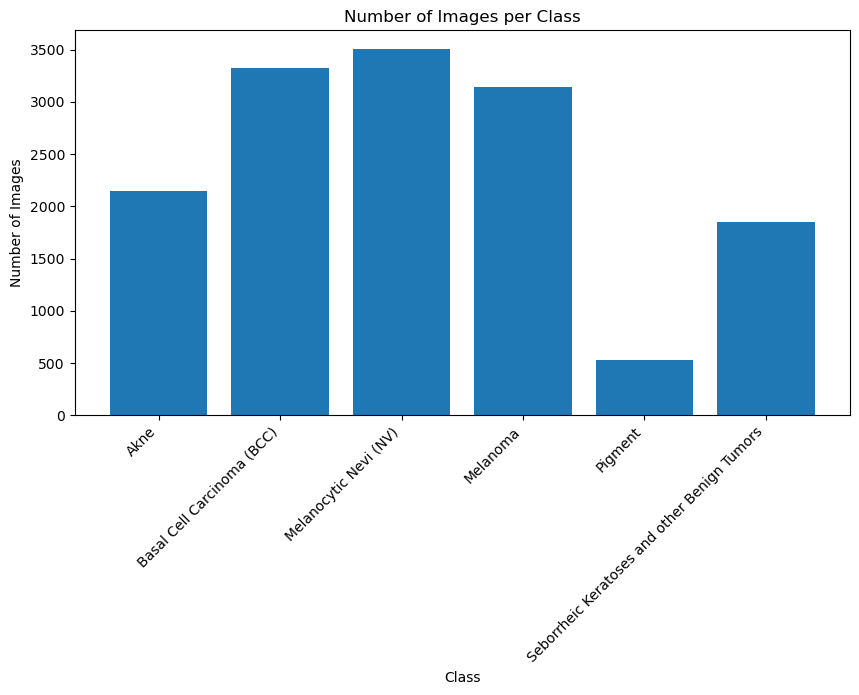

In [4]:
def count_bar(dataset, class_names):
    # Count the number of images per class
    num_images_per_class = [0] * len(class_names)
    for images, labels in dataset:
        for label in labels:
            num_images_per_class[np.argmax(label)] += 1

    # Plot the bar graph
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, num_images_per_class)
    plt.xlabel('Class',)
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45, ha='right')
    plt.show()

count_bar(dataset, class_names)

In [5]:
#to randomly reduce the dataset if can't process more images
# import os
# import random

# def del_images(delete_from_class_dir ,delete_percentage=None , reduced_to_no=None):
#     # Get list of all images in the directory
#     all_images = os.listdir(delete_from_class_dir)

#     if delete_percentage!=None:
#         num_images_to_delete = int(len(all_images) * delete_percentage)
#     else:
#         num_images_to_delete = len(all_images) - reduced_to_no

#     # Randomly select images to delete
#     images_to_delete = random.sample(all_images, num_images_to_delete)

#     # Delete the selected images
#     for image in images_to_delete:
#         os.remove(os.path.join(delete_from_class_dir, image))



# del_images(delete_from_class_dir='dataset/Melanoma',reduced_to_no=3000)
# dataset=load_batches()
# class_names = dataset.class_names            # folder class names 
# print(class_names)
# count_bar(dataset, class_names)

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)       #(    32,      160, 160,3           )        batch has 32 images of shape(256,256 ,3) each
                              #         images     shape of each image

    print(labels_batch.numpy())     # gives classes 0 1 2 of all images in 1st batch of 32

(32, 160, 160, 3)
[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


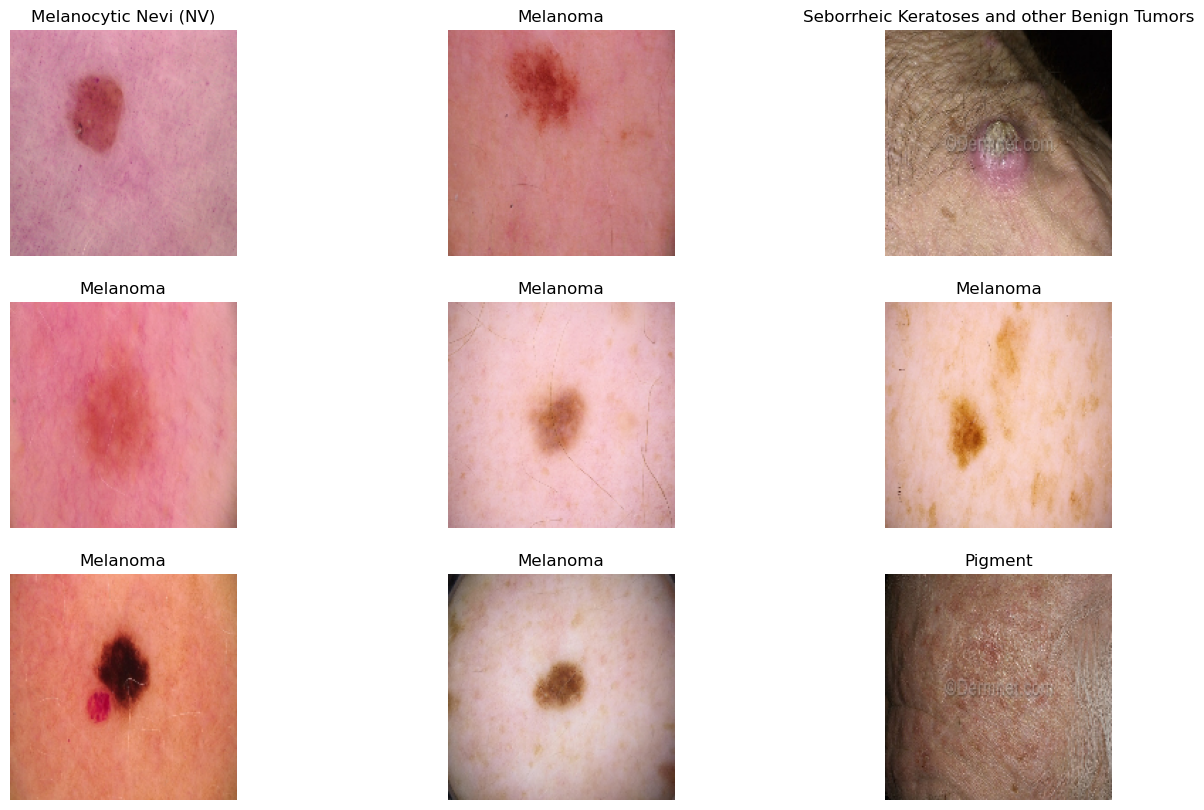

In [8]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels_batch[i])])
        plt.axis("off")

### Function to Split Dataset
1. 80% training
2. 10% validation for each epoch
3. 10% test

In [9]:
# fn for above splitting
def data_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds,test_ds = data_splitting(dataset)       #batches splitting


In [11]:
len(train_ds)

363

In [12]:
len(val_ds)

45

In [13]:
len(test_ds)

46

### Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.8,1.2),

])

Applying Data Augmentation to Train Dataset

In [15]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)


### Cache, Shuffle, and Prefetch the Dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Resize and rescale

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Model Architecture

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)  #4


model = models.Sequential(
    [ 
    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.BatchNormalization(),    
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 160, 160, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 158, 158, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 158, 158, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 79, 79, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 79, 79, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (32, 79, 79, 64)        

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
EPOCHS=100
with tf.device('/GPU:0'):
    epoch_details = model.fit(
                            train_ds,
                            batch_size=BATCH_SIZE,
                            validation_data=val_ds,
                            verbose=1,
                            epochs=EPOCHS,
                        )

Epoch 1/100
363/363 [==============================] - 133s 198ms/step - loss: 1.2462 - accuracy: 0.5510 - val_loss: 1.3010 - val_accuracy: 0.5625
Epoch 2/100
363/363 [==============================] - 28s 76ms/step - loss: 0.9829 - accuracy: 0.6393 - val_loss: 0.9988 - val_accuracy: 0.6687
Epoch 3/100
363/363 [==============================] - 21s 57ms/step - loss: 0.8603 - accuracy: 0.6827 - val_loss: 1.3749 - val_accuracy: 0.5007
Epoch 4/100
363/363 [==============================] - 21s 57ms/step - loss: 0.7750 - accuracy: 0.7113 - val_loss: 1.2221 - val_accuracy: 0.6076
Epoch 5/100
363/363 [==============================] - 21s 57ms/step - loss: 0.7005 - accuracy: 0.7389 - val_loss: 0.6793 - val_accuracy: 0.7396
Epoch 6/100
363/363 [==============================] - 21s 57ms/step - loss: 0.6671 - accuracy: 0.7518 - val_loss: 0.7895 - val_accuracy: 0.6889
Epoch 7/100
363/363 [==============================] - 21s 57ms/step - loss: 0.6197 - accuracy: 0.7707 - val_loss: 0.8717 - val_

In [21]:
model.evaluate(test_ds)

46/46 [==============================] - 48s 36ms/step - loss: 0.8356 - accuracy: 0.8295


[0.8355683088302612, 0.829483687877655]

### Accuracy and Loss Curves

In [22]:
epoch_details.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
epoch_details.history['loss'][:5] # show loss for first 5 epochs

[1.2461656332015991,
 0.9828797578811646,
 0.8602768778800964,
 0.7749772071838379,
 0.700453519821167]

In [24]:
acc = epoch_details.history['accuracy']
val_acc = epoch_details.history['val_accuracy']

loss = epoch_details.history['loss']
val_loss = epoch_details.history['val_loss']

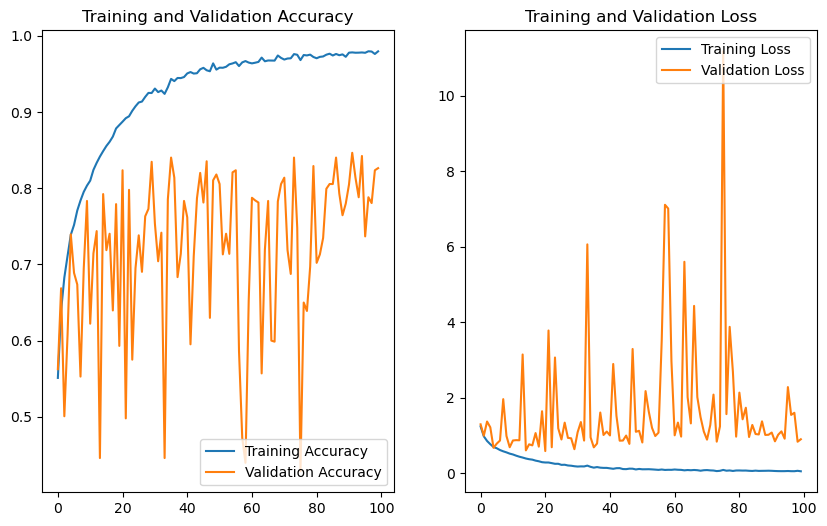

In [25]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Function for Prediction

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### Prediction on sample images

1/1 [==============================] - 0s 23ms/step


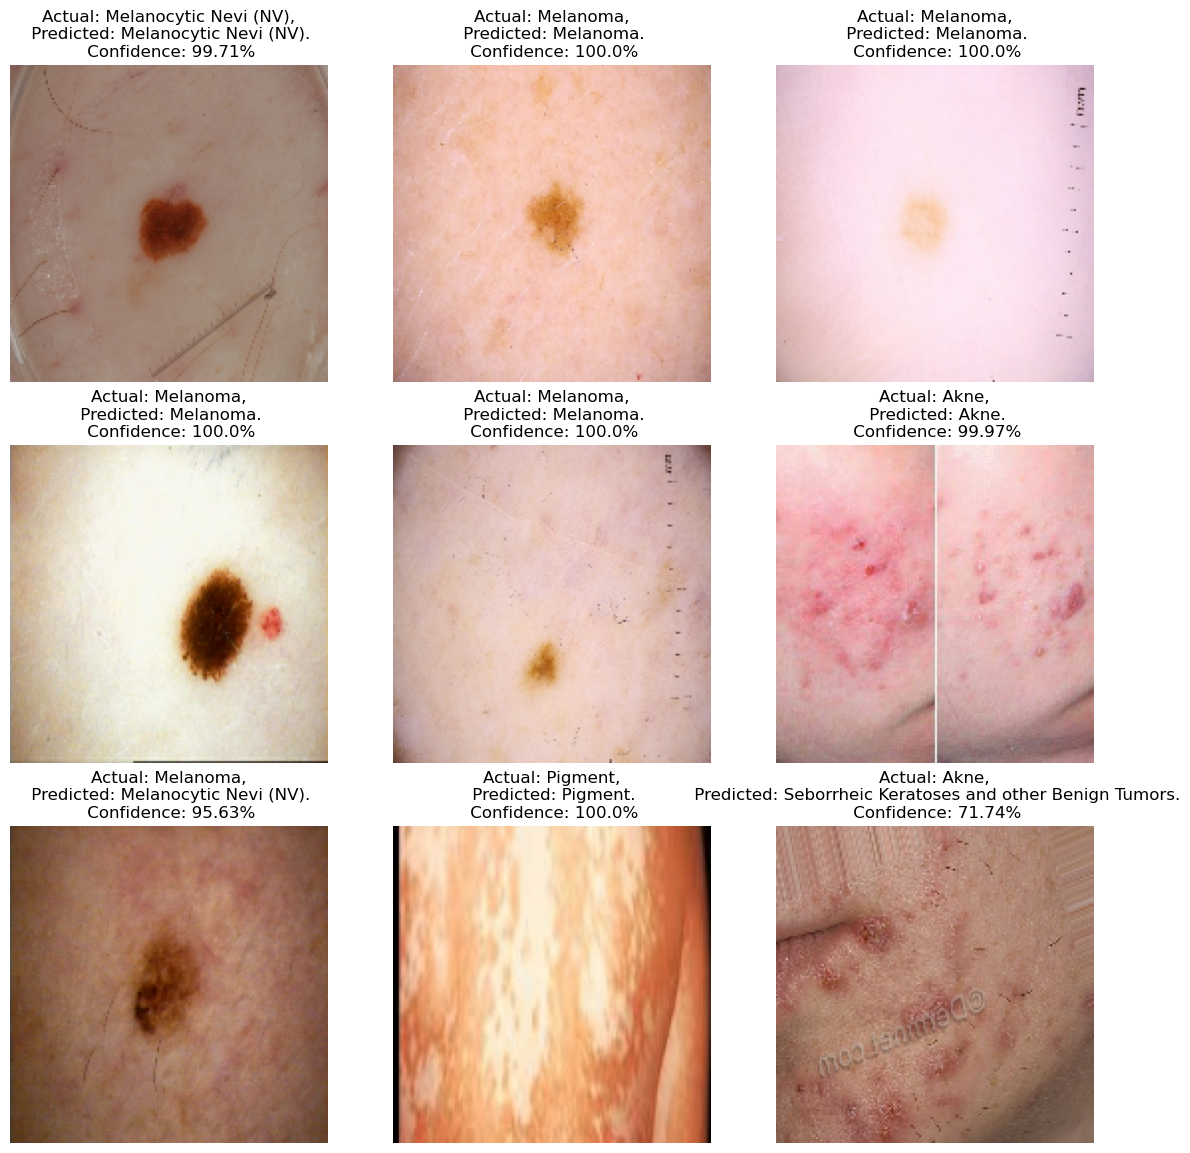

In [27]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [28]:
model.save("skin_diseases_model.h5")